<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/Test/MySpread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals:
* Create a regular squared graph and make the SIR dynamics evolve;
* Add nodes as in the Erdoes-Rényi model + SIR dynamic;
* Check at the S/N, I/N, R/N curves

todo: find the epidemic threshold of the disease

In [1]:
import random
import networkx as nx
import networkx.generators.lattice as lattice
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

# SIR on regular lattice

## Create a squared lattice

In [2]:
print("Hey fella s I'm an VSC locally but tunnelled via ngrok.")

Hey fellas I'm an VSC locally but tunnelled via ngrok.


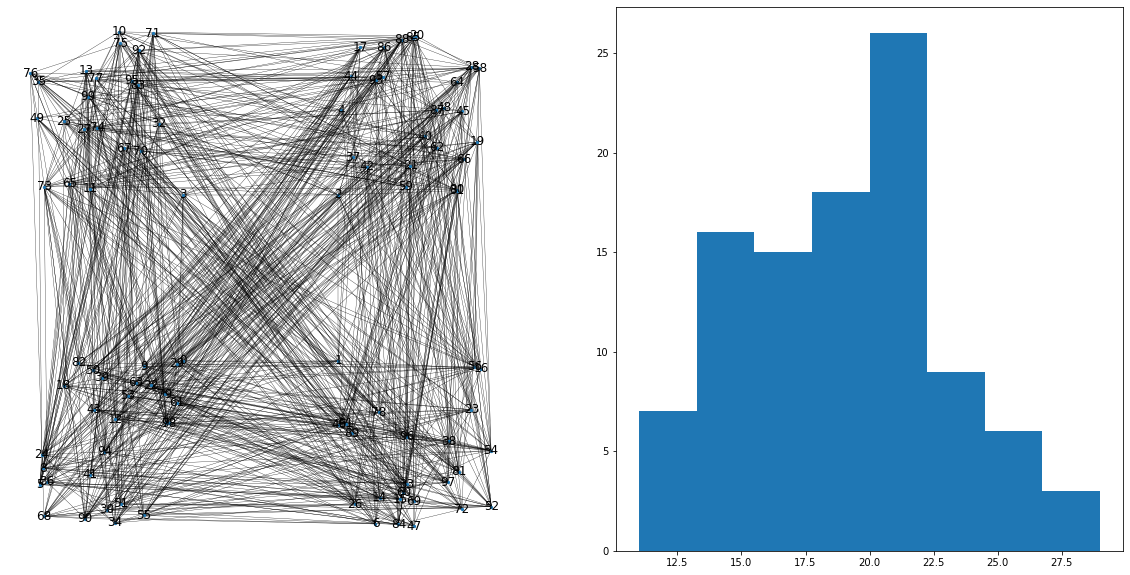

In [98]:
fig, axs = plt.subplots(1,2, figsize=(20,10))


def rgraph(N,p):
    G = nx.Graph()

    'Center the initial squared lattice'
    pos = {0:(0,0),1:(1,0),2:(1,1),3:(0,1)}#dict with two of the positions set
    for i in range(4,N): pos[i]=(random.random()+(-1)**random.randint(0,1), random.random()+(-1)**random.randint(0,1) )

    'Add nodes to graph and "double"-edging'
    G.add_nodes_from(pos.keys())
    for n, coord in pos.items():
      G.nodes[n]['pos'] = coord
    edges = set() #avoid to put same link twice (unordered)
    for i,j in product(range(4), repeat=2):
      if j==(i+1)%4 or j==(i-1)%4: edges.add((i,j))
    for i,j in product(range(N), repeat=2):
      if i != j and random.random() <= p: # with this meth we have 2p of chance of edging. So, the mean=n*2p
        edges.add((i,j))

    'Remove the cross edges within the square'
    disclist=[(0,2),(2,0),(1,3),(3,1)]
    for x in disclist: edges.discard(x)
    G.add_edges_from(edges)

    return G,pos

G,pos=rgraph(100,0.1)

nx.draw(G, ax=axs[0], pos=pos, with_labels=True, font_size=12, node_size=5, width=.3)


def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    axs[1].hist(degrees, bins="auto", log=False, density=0)
plot_degree_dist(G)

## Make the disease spread

In [99]:
def sir(G,beta,mu):
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Label the individual wrt to the # of the node'
    node_labels = G.nodes()
    
    'Currently infected individuals and the future infected and recovered' 
    inf_list = [] 
    prevalence = []
    recovered = []

    'Initial Conditions'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    'Selects the seed of the disease'
    seed = random.choice(range(N)) 
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    inf_list.append(seed)    
   

    while(len(inf_list)>0):        
        
        'Infection Phase: each infected tries to infect all of the neighbors'
        for i in inf_list:
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #only != wrt to the SIS: contact are taken from G.neighbors            
            for j in tests:
                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    if random.random() < beta:
                        future_state[j] = 'I'
                    else:
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            if random.random() < mu:
                future_state[i] = 'R'
            else:
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy() #w/o .copy() it's a mofiable-"view"
       
        'Updates inf_list with the currently fraction of inf/rec' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))

        
    return prevalence, recovered

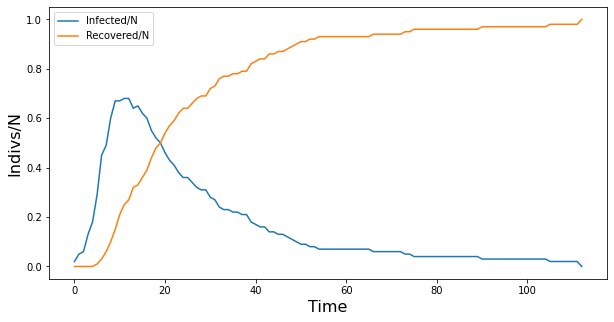

In [114]:
plt.figure(figsize=(10,5))

beta = 0.04 # infection probability
mu = 0.05 # recovery probability

# simulate SIR dynamics and obtain prevalence
prevalence, recovered = sir(G, beta, mu)

plt.plot(prevalence, label="Infected/N")
plt.plot(recovered, label="Recovered/N")

plt.xlabel('Time', fontsize = 16)
plt.ylabel('Indivs/N', fontsize = 16)
plt.legend(loc="best");